# 비정상성을 띄는 삼성전자 주가 예측
## 1. 단순 lgbm 예측

In [1]:
from datetime import datetime
import pandas_datareader.data as wb
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# train 기간 
start = datetime(2018, 5, 3)
end = datetime(2019, 5, 1)

# 예측 기간
y_start = datetime(2019,5,2)
y_end = datetime(2019,5,27)

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# 삼성전자
ss = wb.DataReader('005930.KS', 'yahoo', start, end)
ss_y = wb.DataReader('005930.KS', 'yahoo', y_start, y_end)

In [3]:
# 중간값으로 채우기

ss[ss["Volume"]==0]
ss.loc[ss['Volume'] == 0, 'Volume'] = ss['Volume'].median()

In [4]:
ss.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-05-03,53000.0,53000.0,53000.0,53000.0,10638766.0,51733.824219
2018-05-04,53900.0,51800.0,53000.0,51900.0,39565391.0,50660.105469
2018-05-08,53200.0,51900.0,52600.0,52600.0,23104720.0,51343.382812
2018-05-09,52800.0,50900.0,52600.0,50900.0,16128305.0,49683.992188
2018-05-10,51700.0,50600.0,51700.0,51600.0,13905263.0,50367.269531


In [5]:
print(ss.shape, ss_y.shape)

(241, 6) (17, 6)


In [6]:
ss.reset_index(inplace=True)
ss_y.reset_index(inplace=True)

In [7]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X = ss.drop(columns=['Date', 'Open'])
y = ss['Open']
X_test = ss_y.drop(columns=['Date', 'Open'])
y_test = ss_y['Open']

X.head()

,High,Low,Close,Volume,Adj Close
0,53000.0,53000.0,53000.0,10638766.0,51733.824219
1,53900.0,51800.0,51900.0,39565391.0,50660.105469
2,53200.0,51900.0,52600.0,23104720.0,51343.382812
3,52800.0,50900.0,50900.0,16128305.0,49683.992188
4,51700.0,50600.0,51600.0,13905263.0,50367.269531


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(192, 5) (192,) (49, 5) (49,)
(17, 5) (17,)


In [9]:
import lightgbm as lgb
import math

# parameter 조정
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'max_depth': 10, 
    'learning_rate': 0.5,
    'verbose': 0 }

n_estimators = 100

n_iters = 10

for i in range(n_iters): 
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_test, label=y_test)
    
    watchlist = [d_test]

    model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)

    preds = model.predict(X_test)
    

In [10]:
preds

array([45988.38797419, 45562.31801904, 45430.37595835, 44140.10573069,
       43655.86661001, 43146.49004874, 43115.50048958, 42116.31336367,
       43115.50048958, 40926.60019822, 40364.85163901, 42275.93631261,
       43390.67134129, 43112.56813582, 43112.76384608, 43422.2464648 ,
       43149.12605963])

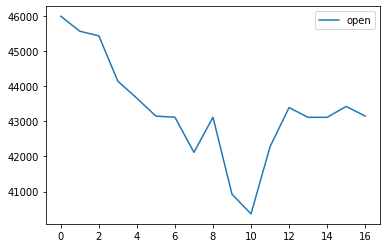

In [11]:
submisson = pd.DataFrame()
submisson['open'] = preds
submisson.plot()

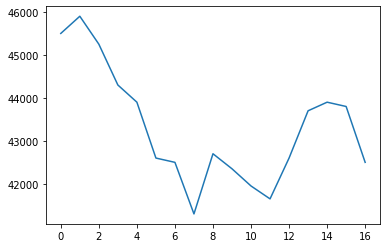

In [12]:
y_test.plot()

In [13]:
submisson.head()

,open
0,45988.387974
1,45562.318019
2,45430.375958
3,44140.105731
4,43655.866610


In [14]:
sub_list = submisson['open'].tolist()
sub_list

[45988.387974188154,
 45562.31801903685,
 45430.375958352626,
 44140.10573069404,
 43655.86661001085,
 43146.49004873895,
 43115.50048958466,
 42116.313363669185,
 43115.50048958466,
 40926.600198220294,
 40364.851639005625,
 42275.93631261223,
 43390.67134129272,
 43112.56813582204,
 43112.76384608442,
 43422.246464804746,
 43149.12605962797]

In [15]:
real = pd.DataFrame()
real['open'] = y_test
real_list = real['open'].tolist()

In [16]:
c=0
for i in range(len(real_list)):
    c+=(real_list[i]-sub_list[i])**2
import math
rmse=math.sqrt(c/17)
rmse

730.4855029844066

## 2. 한달 구간으로 rolling window 진행 후 예측

In [17]:
# 삼성전자
ss = wb.DataReader('005930.KS', 'yahoo', start, end)
ss_y = wb.DataReader('005930.KS', 'yahoo', y_start, y_end)

start = datetime(2018, 5, 3)
end = datetime(2019, 5, 1)

y_start = datetime(2019,5,2)
y_end = datetime(2019,5,27)

feature_names = ['High', 'Low', 'Close', 'Volume', 'Adj Close']

n_samples = 30
y_hats = []
end = int(len(ss) / 30)

for i in range(end+1):
    train_df = ss[:n_samples] # 30개 자름
    if i == end:
        start = datetime(2019,5,2)
        end = datetime(2019,5,27)
        test_df = wb.DataReader('005930.KS', 'yahoo',start,end)
        test_df[test_df["Volume"]==0]
        test_df.loc[test_df['Volume'] == 0, 'Volume'] = test_df['Volume'].median()

    else:
        test_df = ss[n_samples:n_samples+30]

    # lgbm    
    for i in range(n_iters): 
        X = train_df[feature_names]
        y = train_df.Open
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
        
        d_train = lgb.Dataset(X_train, label=y_train)
        d_test = lgb.Dataset(X_valid, label=y_valid)

        watchlist = [d_test]

        model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)

        r_preds = model.predict(test_df[feature_names])

    n_samples = n_samples + 30
    
    if n_samples > len(ss):
        n_smaples = len(ss)

In [18]:
window_pred = r_preds.tolist() #array list 변환
window_pred

[46118.709896880195,
 45517.040132920294,
 45357.01629292352,
 44413.58021413945,
 43378.12323064249,
 43235.753489473034,
 42593.118563103446,
 42847.16506750689,
 42961.0669477965,
 41942.4723270952,
 40546.443129968575,
 42320.06278635005,
 43419.190034600695,
 43040.74128869214,
 43300.85490951998,
 43229.425784049294,
 42893.74542553777]

In [19]:
c=0
for i in range(len(real_list)):
    c+=(real_list[i]-window_pred[i])**2
import math
rmse=math.sqrt(c/17)
rmse

695.8360270061705